## 공공데이터 활용 국토교통부 아파트매매 실거래가 OpenAPI 연동 <br>

### 공공데이터포털 :  *https://www.data.go.kr/data/15058747/openapi.do*
### 행정표준코드관리시스템 :  *https://www.code.go.kr/index.do*  <br>

*행정표준코드관리시스템(www.code.go.kr) 으로부터 전국 법정동 정보를 얻어온 뒤, 공공데이터포털(www.data.go.rk) 의 OpenAPI 활용 가이드에 따라 지역코드와 기간을 이용하여 해당기간, 해당지역의 아파트 매매 신고 정보를 조회하고 저장하고자 한다.* <br>
*GitHub Link: https://github.com/YoungJuJang/Using-Open-Data-OpenAPI*

#### 국토교통부 아파트 매매 실거래가 정보 오픈API 활용 가이드

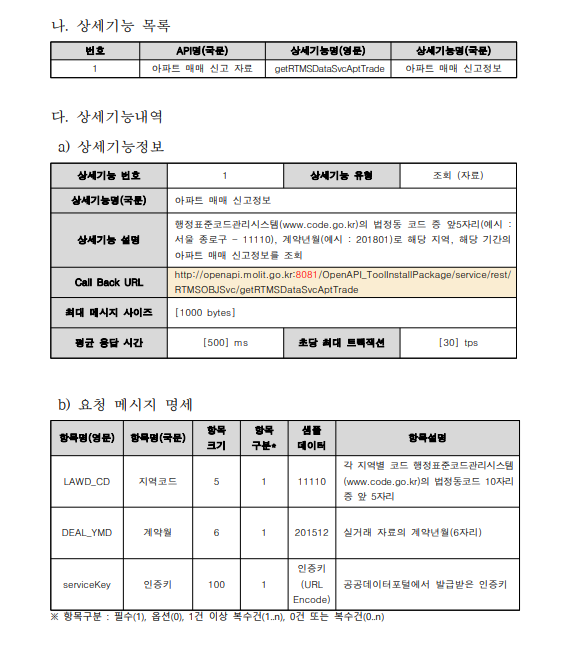

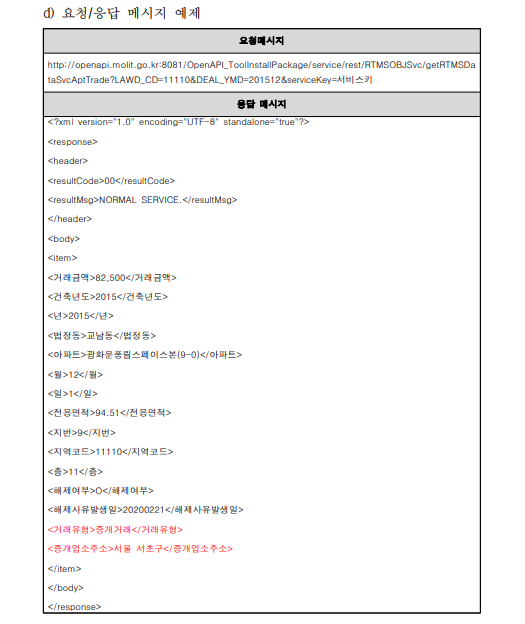

&nbsp; &nbsp; &rightarrow; 정보 조회를 위한 요청메시지는 서비스 URL(Call Back URL)과 지역코드, 계약월, 인증키(개인)의 조합으로 이루어져 있다.

<br>

## 1. Import Packages

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

<br>

## 2. Data loading
- 행정표준코드관리시스템으로부터 법정동 코드 파일을 전체 다운받아 사용

In [2]:
# 전체 법정동 코드가 담긴 데이터

lawd_txt = pd.read_csv("법정동코드 전체자료.txt", encoding='cp949', sep="\t")

print(lawd_txt.shape)
lawd_txt.head()

(46328, 3)


,법정동코드,법정동명,폐지여부
0,1100000000,서울특별시,존재
1,1111000000,서울특별시 종로구,존재
2,1111010100,서울특별시 종로구 청운동,존재
3,1111010200,서울특별시 종로구 신교동,존재
4,1111010300,서울특별시 종로구 궁정동,존재


In [3]:
# 폐지되지 않은 법정동의 법정동코드 앞5자리만 추출하는 함수

def find_lawd_cd(lawd_input):
    return lawd_txt[lawd_txt["법정동명"].str.contains(lawd_input) & (lawd_txt["폐지여부"] == "존재")].iloc[0,0].astype(str)[0:5]

In [4]:
# 조회할 지역을 입력하고 해당 지역의 법정동코드(앞5자리)인 지역코드를 저장

lawd_input = input("조회하려는 지역(구, 동) : ")

lawd_cd = find_lawd_cd(lawd_input) # 지역코드
print("\n조회할 지역: ", lawd_input, "\n해당 지역의 지역코드: ", lawd_cd)

조회하려는 지역(구, 동) : 서초구

조회할 지역:  서초구 
해당 지역의 지역코드:  11650


In [6]:
# 조회할 년월 입력

deal_input = input("조회하려는 년월(예: 202202) : ") # 계약월
print("\n계약월: ", deal_input)

조회하려는 년월(예: 202202) : 202109

계약월:  202109


<br>

- #### 서비스 명세의 요청 메시지 구분

> "*서비스 URL*"  +   "*?*"  +   <br> 
"*LAWD_CD=*"  +  "*지역코드*"  +  "*&*"  +  <br> 
"*DEAL_YMD=*"  +  "*계약월*"  +  "*&*"  +  <br> 
"*serviceKey=서비스키(인증키)*"

In [7]:
# 서비스 URL, 지역코드, 계약월을 구분하여 저장
base_url = "http://openapi.molit.go.kr:8081/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTrade?"
sub_url1 = "LAWD_CD=" + lawd_cd + "&"
sub_url2 = "DEAL_YMD=" + deal_input + "&"

In [8]:
# 개인 서비스키(인증키)
svc_key = "serviceKey=fq448BTENSGVmu47zvzjDudVK1LUOPdIONYmOk774uKTYukGYTIZdMjVIURNLrwHFbDrRgCZRXehyB%2FR2YxQ5A%3D%3D"

In [9]:
# 최종 요청 메시지
url = base_url + sub_url1 + sub_url2 + svc_key
url

'http://openapi.molit.go.kr:8081/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTrade?LAWD_CD=11650&DEAL_YMD=202109&serviceKey=fq448BTENSGVmu47zvzjDudVK1LUOPdIONYmOk774uKTYukGYTIZdMjVIURNLrwHFbDrRgCZRXehyB%2FR2YxQ5A%3D%3D'

In [10]:
# 요청 응답 결과 
resp = requests.get(url)
resp # 정상 [200]

<Response [200]>

<br>

## 3. XML parsing
- XML로 이루어진 요청에 대한 응답메시지 태그들을 파싱하여 리스트 내 딕셔너리 형태로 저장시킨 후 데이터프레임으로 변환

In [11]:
import xml.etree.ElementTree as ET

def find_xml_items(response):
    root = ET.fromstring(response.content)
    item_list = []
    for child in root.find('body').find('items'):
        elements = child.findall('*')
        data = {}
        for element in elements:
            tag = element.tag.strip()
            text = element.text.strip()
            # print tag, text
            data[tag] = text
        item_list.append(data)  
    return item_list
    
items_list = find_xml_items(resp)
items_list

[{'거래금액': '30,000',
  '거래유형': '',
  '건축년도': '2005',
  '년': '2021',
  '법정동': '방배동',
  '아파트': '방배대우디오빌',
  '월': '9',
  '일': '1',
  '전용면적': '29.6',
  '중개사소재지': '',
  '지번': '866-20',
  '지역코드': '11650',
  '층': '9',
  '해제사유발생일': '',
  '해제여부': ''},
 {'거래금액': '283,000',
  '거래유형': '',
  '건축년도': '2013',
  '년': '2021',
  '법정동': '방배동',
  '아파트': '롯데캐슬아르떼',
  '월': '9',
  '일': '3',
  '전용면적': '216.2766',
  '중개사소재지': '',
  '지번': '424-28',
  '지역코드': '11650',
  '층': '13',
  '해제사유발생일': '',
  '해제여부': ''},
 {'거래금액': '250,000',
  '거래유형': '',
  '건축년도': '2002',
  '년': '2021',
  '법정동': '방배동',
  '아파트': '현대멤피스',
  '월': '9',
  '일': '3',
  '전용면적': '158.82',
  '중개사소재지': '',
  '지번': '772-13',
  '지역코드': '11650',
  '층': '14',
  '해제사유발생일': '',
  '해제여부': ''},
 {'거래금액': '192,500',
  '거래유형': '',
  '건축년도': '1992',
  '년': '2021',
  '법정동': '방배동',
  '아파트': '대우(효령)',
  '월': '9',
  '일': '4',
  '전용면적': '84.93',
  '중개사소재지': '',
  '지번': '1038',
  '지역코드': '11650',
  '층': '4',
  '해제사유발생일': '',
  '해제여부': ''},
 {'거래금액': '205,000',
  '거

In [12]:
result = pd.DataFrame(items_list)

print(result.shape)
result.head(10)

(133, 15)


,거래금액,거래유형,건축년도,년,법정동,아파트,월,일,전용면적,중개사소재지,지번,지역코드,층,해제사유발생일,해제여부
0,"30,000",,2005,2021,방배동,방배대우디오빌,9,1,29.6,,866-20,11650,9,,
1,"283,000",,2013,2021,방배동,롯데캐슬아르떼,9,3,216.2766,,424-28,11650,13,,
2,"250,000",,2002,2021,방배동,현대멤피스,9,3,158.82,,772-13,11650,14,,
3,"192,500",,1992,2021,방배동,대우(효령),9,4,84.93,,1038,11650,4,,
4,"205,000",,1996,2021,방배동,두원,9,5,84.87,,473-1,11650,3,,
5,"203,000",,2010,2021,방배동,서리풀e편한세상,9,9,59.94,,906-13,11650,11,,
6,"212,000",,2001,2021,방배동,방배2차현대홈타운,9,10,84.94,,2001,11650,8,,
7,"90,000",,2019,2021,방배동,방배마에스트로,9,10,29.28,,866-10,11650,22,,
8,"337,000",,2009,2021,방배동,방배롯데캐슬로제,9,10,204.41,,849-30,11650,7,21.10.06,O
9,"337,000",,2009,2021,방배동,방배롯데캐슬로제,9,10,204.41,,849-30,11650,7,,


<br>

## 4. Save file

In [13]:
import datetime

In [14]:
today = datetime.datetime.today()
datetime.date.strftime(today, '%Y%m%d')

'20221021'

In [15]:
f_name = lawd_input + "_" + deal_input + "-" + datetime.date.strftime(today, '%Y%m%d') + ".csv"
f_name

'서초구_202109-20221021.csv'

In [16]:
result.to_csv(f_name, encoding='cp949', index=False)